# NCAR CGD Machine Learning Tutorial
David John Gagne

## Notebook Requirements
* Python: 3.6 or newer
* Installer: Miniconda or Anaconda
* Libraries
  * numpy
  * scipy
  * matplotlib
  * pandas
  * scikit-learn
  * jupyter
  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
from os.path import exists, join
import os
import tarfile
from urllib.request import urlretrieve
import glob
import matplotlib.pyplot as plt

## What is Machine Learning?
Machine learning is a broad family of algorithms that map a set of input data to one or more outcomes assuming a certain kind of model structure, such as a neural network or a decision tree. Machine learning models generally try to learn their mappings from the data directly with few prior assumptions about distributions and relationships within the data. 

### Types of Machine Learning Approaches
1. Supervised learning: You have a defined target output that you want to predict. This can be a classification or a regression problem. Example: Given today's weather conditions, predict the chance of rain tomorrow.

2. Unsupervised learning: You do not have a defined target but either want to group your data into similar subsets (clustering) or you want to approximate the distribution of your input data and sample from it (generative modeling). Example: Group the 500 hPa geopotential height patterns over the US for the past 40 years into 5 regimes. 

3. Reinforcement learning: You have an entity that wants to perform a task in a way that maximizes a reward function. Example: If I were a duck that prefers certain ranges of temperature, humidity, and rainfall, where would I migrate  over a 50 year period to maximize my comfort?


## How Can ML Assist with Climate Science?
* Analysis
  * Find features of interest in observational and modeling datasets
  * Map between different fields
  * Reduce dimensionality of large datasets
  * Link climate to non-climate variables.
* Prediction
  * Subseasonal-to-Seasonal Forecasting
* Parameterization
  * Emulate existing sub-grid parameterization schemes
  * Create new parameterizations from observations or higher-complexity model datasets
* Assimilation
  * Map non-climate variables into a form that can be ingested into numerical models
* Optimization
  * Find model settings that minimize observational error and fulfill other constraints

## Pre-Processing
Our examples will use statistical data describing a large set of simulated storms from a set of convection-allowing WRF runs produced by MMM. We have information about radar reflectivity, surface temperature, and 10-m u and v winds along with the maximum vorticity and hail size associated with each storm.

In [2]:
# If you are on your local machine and want to download the module data, run this cell.
if not exists("tornado_data"):
    os.mkdir("tornado_data")
csv_tar_file = "https://storage.googleapis.com/track_data_ncar_ams_3km_csv_small/track_data_ncar_ams_3km_csv_small.tar.gz"
print("Get csv files")
urlretrieve(csv_tar_file, join("tornado_data", csv_tar_file.split("/")[-1]))
print("Extract csv tar file")
csv_tar = tarfile.open(join("tornado_data", csv_tar_file.split("/")[-1]))
csv_tar.extractall("tornado_data/")
csv_tar.close()
path = "tornado_data/track_data_ncar_ams_3km_csv_small/"

Get csv files
Extract csv tar file


In [4]:
# If you are on a Cheyenne compute node, run this cell.
path = "/glade/work/dgagne/track_data_ncar_ams_3km_csv_small/"

In [3]:
files = sorted(glob.glob(path+"/*.csv"))
data = pd.concat([pd.read_csv(f, parse_dates=["Run_Date", "Valid_Date"]) for f in files], ignore_index=True)

In [10]:
for col in data.columns:
    print(col)

Step_ID
Track_ID
Ensemble_Name
Ensemble_Member
Run_Date
Valid_Date
Forecast_Hour
Valid_Hour_UTC
Duration
Centroid_Lon
Centroid_Lat
Centroid_X
Centroid_Y
Storm_Motion_U
Storm_Motion_V
REFL_COM_mean
REFL_COM_max
REFL_COM_min
REFL_COM_std
REFL_COM_percentile_10
REFL_COM_percentile_25
REFL_COM_percentile_50
REFL_COM_percentile_75
REFL_COM_percentile_90
U10_mean
U10_max
U10_min
U10_std
U10_percentile_10
U10_percentile_25
U10_percentile_50
U10_percentile_75
U10_percentile_90
V10_mean
V10_max
V10_min
V10_std
V10_percentile_10
V10_percentile_25
V10_percentile_50
V10_percentile_75
V10_percentile_90
T2_mean
T2_max
T2_min
T2_std
T2_percentile_10
T2_percentile_25
T2_percentile_50
T2_percentile_75
T2_percentile_90
RVORT1_MAX-future_mean
RVORT1_MAX-future_max
RVORT1_MAX-future_min
RVORT1_MAX-future_std
RVORT1_MAX-future_percentile_10
RVORT1_MAX-future_percentile_25
RVORT1_MAX-future_percentile_50
RVORT1_MAX-future_percentile_75
RVORT1_MAX-future_percentile_90
HAIL_MAXK1-future_mean
HAIL_MAXK1-future

For our machine learning models, we shall select a set of input variables and an output label. We will also split our data into separate training and testing sets based on a splitting date to keep the two sets temporally independent. 

In [4]:
input_columns = ["REFL_COM_mean", "U10_mean", "V10_mean", "T2_mean", "area", "eccentricity", "orientation"]
output_column = "HAIL_MAXK1-future_max"
split_date = pd.Timestamp("2015-01-01")
train_data_in = data.loc[data["Run_Date"] < split_date, input_columns]
train_data_out = data.loc[data["Run_Date"] < split_date, output_column]
test_data_in = data.loc[data["Run_Date"] >= split_date, input_columns]
test_data_out = data.loc[data["Run_Date"] >= split_date, output_column]

Text(0.5, 1.0, 'HAIL_MAXK1-future_max')

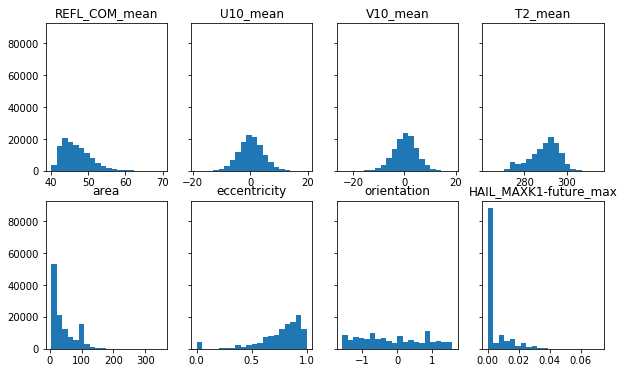

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6), sharey=True)
axef = axes.ravel()
num_bins = 20
for c, col in enumerate(input_columns):
    axef[c].hist(data[col], bins=num_bins)
    axef[c].set_title(col)
axef[-1].hist(data[output_column], bins=num_bins)
axef[-1].set_title(output_column)

## Unsupervised Learning
The goal of unsupervised learning is to optimally divide a large dataset into more similar groups and analyze the properties of each group to identify common patterns. Unsupervised learning models can also be used to generate new samples from their respective distributions.

We will cover two related unsupervised learning techniques, K-Means Clustering and Gaussian Mixture Models. 

K-Means clustering is a method for iteratively dividing a set of points into _k_ discrete groups based on their distance from the center of each cluster. 

Gaussian Mixture Models approximate a joint probability distribution with _k_ multivariate Gaussian distributions and iteratively optimize the distribution means and covariances. Gaussian Mixture Models allow one to calculate the probability of being associated with each distribution and enable sampling of new points from the joint distribution. 

We will demonstrate how the scikit-learn implementations of both models work below.

In [73]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

First we will plot the joint distribution of mean 2 m temperature and composite radar reflectivity from our training data.

Text(0, 0.5, 'REFL_COM_mean')

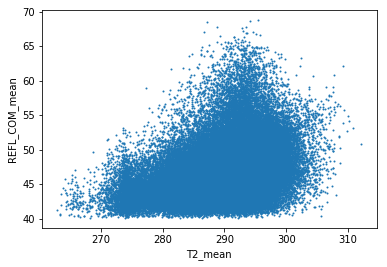

In [74]:
plt.scatter(train_data_in["T2_mean"], train_data_in["REFL_COM_mean"], 1)
plt.xlabel("T2_mean")
plt.ylabel("REFL_COM_mean")

We will fit a set of 4 clusters using k-means.

In [75]:
km = KMeans(n_clusters=4)
km.fit(train_data_in[["T2_mean", "REFL_COM_mean"]])
cluster_ids = km.predict(train_data_in[["T2_mean", "REFL_COM_mean"]])

The clusters are based on Euclidean distance and are thus fairly globular.

Text(0.5, 1.0, 'K-means Clusters')

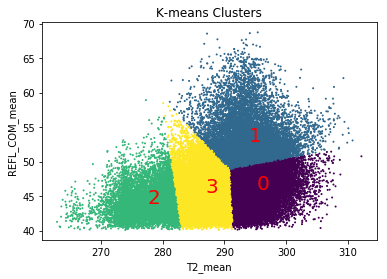

In [91]:
plt.scatter(train_data_in["T2_mean"], train_data_in["REFL_COM_mean"], 1, cluster_ids)
for cid in np.unique(cluster_ids):
    plt.text(km.cluster_centers_[cid, 0], km.cluster_centers_[cid, 1], str(cid), fontsize=20, color="red")
plt.xlabel("T2_mean")
plt.ylabel("REFL_COM_mean")
plt.title("K-means Clusters")

We can plot the frequency of cluster occurrence in lat-lon space to see if there is any geographical clustering to go with our meteorological information. We do see some north-south variability in the location of points belonging to each cluster.

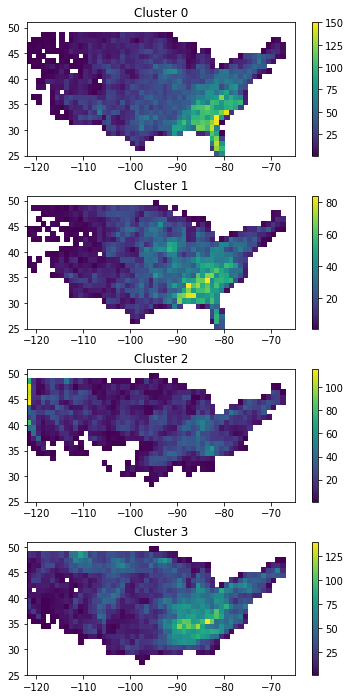

In [95]:
fig, axes = plt.subplots(4, 1, figsize=(6, 12))
plt.subplots_adjust(hspace=0.3)
for cid in np.unique(cluster_ids):
    out = axes[cid].hist2d(data.loc[train_data_in.index[cluster_ids == cid], "Centroid_Lon"], 
                data.loc[train_data_in.index[cluster_ids == cid], "Centroid_Lat"], 
                     bins=(np.arange(-122, -64, 1.0), np.arange(25, 52, 1.0)), cmin=1)
    plt.colorbar(out[-1], ax=axes[cid])
    axes[cid].set_title(f"Cluster {cid:d}")

Now we will cluster the data using Gaussian Mixture Models. We should get mostly a similar result to K-means.

In [79]:
gmm = GaussianMixture(n_components=4)
gmm.fit(train_data_in[["T2_mean", "REFL_COM_mean"]])
cluster_ids_gmm = gmm.predict(train_data_in[["T2_mean", "REFL_COM_mean"]])

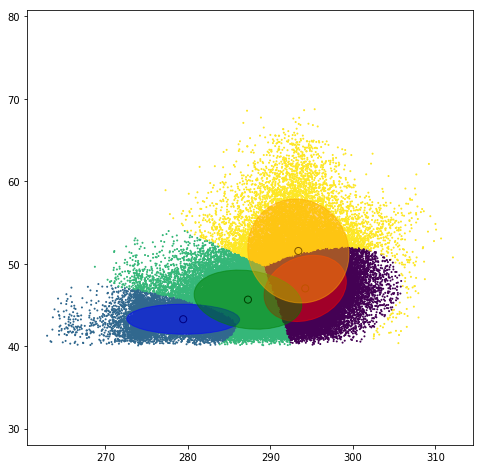

In [80]:
colors = ["red", "blue", "green", "orange"]
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(train_data_in["T2_mean"], train_data_in["REFL_COM_mean"], 1, cluster_ids_gmm)
ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 50, np.arange(4), edgecolors="k")
make_ellipses(gmm, ax)
#plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1])

The gaussian mixtures are overlaid with the points. We see that the different covariances for the clusters result in some points changing ID compared with K-means, which only considered distance from the cluster center.

We can also sample new synthetic points from our Gaussian Mixture. This sampling procedure could be used for stochastic modeling applications. 

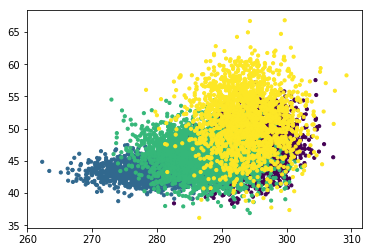

In [88]:
generated_samples, sample_ids = gmm.sample(10000)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], 10, sample_ids)

## Supervised Learning
For supervised learning we will train two common machine learning models using the scikit-learn interface. 

* Logistic Regression: a linear regression model with the logit transform of the output to produce values from 0 to 1.
* Random Forest: an ensemble of decision trees with bootstrap resampling of the training data for each tree and random subset selection of input variables.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Fit logistic regression model
lr = LogisticRegression(penalty="l2", C=0.1)
lr.fit(train_data_in, train_data_out > 0)
# Fit Random forest
rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_features="sqrt", max_leaf_nodes=500)
rf.fit(train_data_in, train_data_out > 0)


/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=500,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Model Evaluation
Once our models are trained, we will evaluate their performance on the test set.

In [7]:
test_probs = pd.DataFrame(0, index=np.arange(test_data_out.shape[0]), columns=["Logistic Regression", "Random Forest"])
test_probs.loc[:, "Logistic Regression"] = lr.predict_proba(test_data_in)[:, 1]
test_probs.loc[:, "Random Forest"] = rf.predict_proba(test_data_in)[:, 1]


A common metric for classifier model performance is the receiver operator characteristic (ROC) curve. The ROC curve splits the predicted probabilities into binary classifications at different thresholds and calculated the Probability of Detection and Probability of False Detection at each threshold. 

The area under the ROC Curve (AUC) is correlated with increasing skill in discriminating between two outcomes.

The Brier Score is the Mean Squared Error for probability forecasts. It can be decomposed in different ways to estimate both reliability and sharpness of predictions.

Text(0, 0.5, 'Probability of Detection')

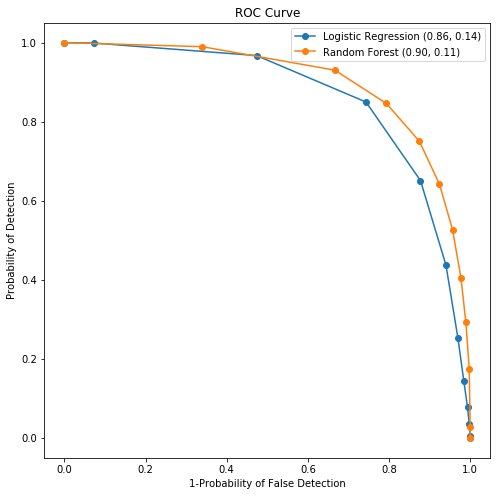

In [97]:
from sklearn.metrics import brier_score_loss, roc_curve, roc_auc_score

rocs = {}
plt.figure(figsize=(8, 8))
for col in test_probs.columns:
    rocs[col] = roc_curve(test_data_out > 0, np.round(test_probs[col].values, 1))
    auc = roc_auc_score(test_data_out > 0, np.round(test_probs[col].values, 1))
    bs = brier_score_loss(test_data_out > 0, np.round(test_probs[col].values, 1))
    plt.plot(1-rocs[col][0], rocs[col][1], marker='o', label=col + f" ({auc:0.2f}, {bs:0.2f})")
    
plt.legend(loc=0)
plt.title("ROC Curve")
plt.xlabel("1-Probability of False Detection")
plt.ylabel("Probability of Detection")

## Model Interpretation
We can interpret our ML models with two model-agnostic methods, permutation feature importance and partial dependence plots.

Permutation feature importance is a method for ranking the contribution of each input to a given model by estimating how much removing an input worsens the model predictions. For each input, the values are shuffled among the samples to remove the information content of the variable. The shuffled data are fed through the model. The change in the score compared with the unshuffled data provides an estimate of "importance."

In [25]:
def permutation_feature_importance(input_data, output_data, model, score=roc_auc_score):
    original_error = score(output_data, model.predict_proba(input_data)[:, 1])
    permuted_scores = np.zeros(input_data.shape[1])
    permuted_data = np.copy(input_data)
    permuted_indices = np.arange(input_data.shape[0])
    for c in range(input_data.shape[1]):
        np.random.shuffle(permuted_indices)
        permuted_data[:, c] = input_data[permuted_indices, c]
        permuted_scores[c] = score(output_data, model.predict_proba(permuted_data)[:, 1])
        permuted_data[:, c] = input_data[:, c]
    return original_error, permuted_scores

In [28]:
rf_original, rf_permuted = permutation_feature_importance(train_data_in.values, train_data_out > 0, rf)
lr_original, lr_permuted = permutation_feature_importance(train_data_in.values, train_data_out > 0, rf)

[    0     1     2 ... 76374 76375 76376]
[    0     1     2 ... 76374 76375 76376]


Text(0.5, 1.0, 'Logistic Regression Importances')

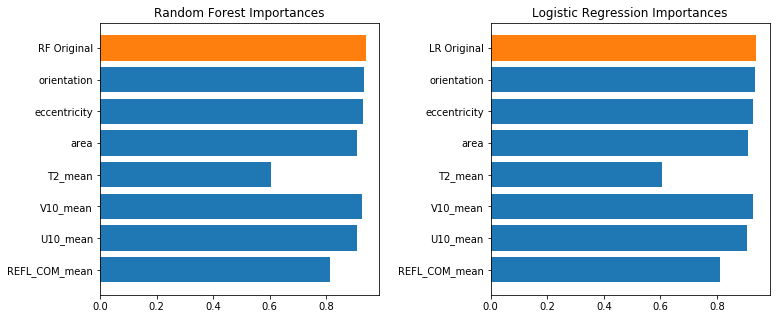

In [42]:
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
plt.barh(np.arange(rf_permuted.size), rf_permuted)
plt.barh(rf_permuted.size, rf_original)
plt.yticks(np.arange(rf_permuted.size + 1), train_data_in.columns.values.tolist() + ["RF Original"])
plt.title("Random Forest Importances")
plt.subplot(1, 2, 2)
plt.barh(np.arange(lr_permuted.size), lr_permuted)
plt.barh(lr_permuted.size, lr_original)
plt.yticks(np.arange(rf_permuted.size + 1), train_data_in.columns.values.tolist() + ["LR Original"])
plt.title("Logistic Regression Importances")

Partial dependence plots provide information on why a variable is important. In particular it illustrates where in the range of input values the predictions change the most. To calculate partial dependence, the values of an input for all samples are set to the same number. Then, the altered data are sent through the model to calculate the model prediction. The same procedure is applied to a range of values to produce partial dependence curves for each sample. The mean prediction at each point is the aggregate partial dependence. If the individual sample curves are plotted together, they form an Individual Conditional Expectation (ICE) plot that can sometimes show different partial dependence regimes.

In [54]:
def partial_dependence_plot(input_data, model, points=10):
    pd_points = np.zeros((input_data.shape[1], points))
    pd_pred_vals = np.zeros((input_data.shape[1], points, input_data.shape[0]))
    fixed_data = np.copy(input_data)
    for i in range(input_data.shape[1]):
        print(i)
        pd_points[i] = np.linspace(input_data[:, i].min(), input_data[:, i].max(), points)
        for p, point in enumerate(pd_points[i]):
            fixed_data[:, i] = point
            pd_pred_vals[i, p] = model.predict_proba(fixed_data)[:, 1]
        fixed_data[:, i] = input_data[:, i]
    return pd_points, pd_pred_vals

In [55]:
rf_pd_points, rf_pd_pred_vals = partial_dependence_plot(train_data_in.values, rf)

0
1
2
3
4
5
6


In [57]:
lr_pd_points, lr_pd_pred_vals = partial_dependence_plot(train_data_in.values, lr)

0
1
2
3
4
5
6


Below we plot the partial dependence curves for the random forest and logistic regression as well as a selection of ICE curves for the random forest.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12d0d4630>,
      dtype=object)

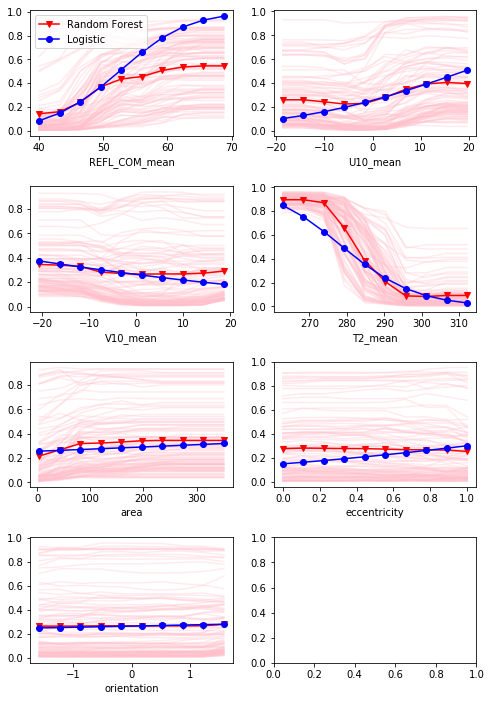

In [71]:
fig, axes = plt.subplots(4, 2, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)
axef = axes.ravel()
random_rows = np.random.randint(0, train_data_in.shape[0], size=100)
for i in range(train_data_in.shape[1]):
    axef[i].plot(rf_pd_points[i], rf_pd_pred_vals[i, :, random_rows].T, color="pink", alpha=0.3)
    axef[i].plot(rf_pd_points[i], rf_pd_pred_vals[i].mean(axis=1), marker='v', color="red", label="Random Forest")
    axef[i].plot(lr_pd_points[i], lr_pd_pred_vals[i].mean(axis=1), marker='o', color="blue", label="Logistic")
    if i == 0:
        axef[i].legend()
    axef[i].set_xlabel(train_data_in.columns[i])
axef

### Machine Learning and Deep Learning Books
* Introduction to Statistical Learning by G. James et al. (https://www-bcf.usc.edu/~gareth/ISL/)
* The Elements of Statistical Learning by T. Hastie et al. (https://web.stanford.edu/~hastie/ElemStatLearn/)
* Deep Learning by I. Goodfellow et al. (https://www.deeplearningbook.org/)
* Deep Learning with Python by F. Chollet (https://www.manning.com/books/deep-learning-with-python)
* Interpretable Machine Learning by Christoph Molnar (https://christophm.github.io/interpretable-ml-book/)

### What are some examples of machine codes applied to weather problems?

* AMS Short Course on Machine Learning in Python for Environmental Science Problems: https://github.com/djgagne/ams-ml-python-course
* Swirlnet Deep Learning Tutorial: https://github.com/djgagne/swirlnet
* California Rainfall Prediction Hackathon: https://www2.cisl.ucar.edu/events/workshops/climate-informatics/2017/hackathon
